<a href="https://colab.research.google.com/github/gorzanskik-ai/PKO-BP/blob/main/02_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/job/PKO BP/polish_sentiment_dataset_clean.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

Zrezygnowałem z klasy neutralnej (0.0).

In [39]:
df = pd.read_csv(path)
df = df[df['rate'] != 0.0]

In [40]:
df.dropna(inplace=True)
df['rate'].value_counts()

rate
 1.0    681126
-1.0    163468
Name: count, dtype: int64

In [41]:
X = df['description'].copy()
y = df['rate'].copy()

Kodowanie klas

In [42]:
le = LabelEncoder()
y = le.fit_transform(y)

In [43]:
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
mapping

{-1.0: 0, 1.0: 1}

Podział dane na testowe i treningowe. Zbiór testowy stanowi 20% całości.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (675675,)
y_train shape: (675675,)
X_test shape: (168919,)
y_test shape: (168919,)


# 1. Bag of words

Wektoryzacja tekstu

In [46]:
vectorizer_bow = CountVectorizer(ngram_range=(1, 3))
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

print(f'X_train shape: {X_train_bow.shape}')
print(f'X_test shape: {X_test_bow.shape}')

X_train shape: (675675, 3772016)
X_test shape: (168919, 3772016)


Model regresji logistycznej

In [47]:
lr_bow = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)
lr_bow.fit(X_train_bow, y_train)
y_pred_lr_bow = lr_bow.predict(X_test_bow)
print(f'Accuracy of Logistic regression: {accuracy_score(y_test, y_pred_lr_bow)}')

Accuracy of Logistic regression: 0.9924993636003054


Raport klasyfikacji

In [48]:
cr = classification_report(y_test, y_pred_lr_bow)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     32481
           1       1.00      0.99      1.00    136438

    accuracy                           0.99    168919
   macro avg       0.99      0.99      0.99    168919
weighted avg       0.99      0.99      0.99    168919



Macierz konfuzji

In [49]:
cm = confusion_matrix(y_test, y_pred_lr_bow)

def plot_confusion_matrix(cm):
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_neg', 'pred_pos'], index=['true_positive', 'true_negative'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=400, height=400, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

In [50]:
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

False Positive Rate (FPR): 0.0159
False Negative Rate (FNR): 0.0055


Krzywa ROC

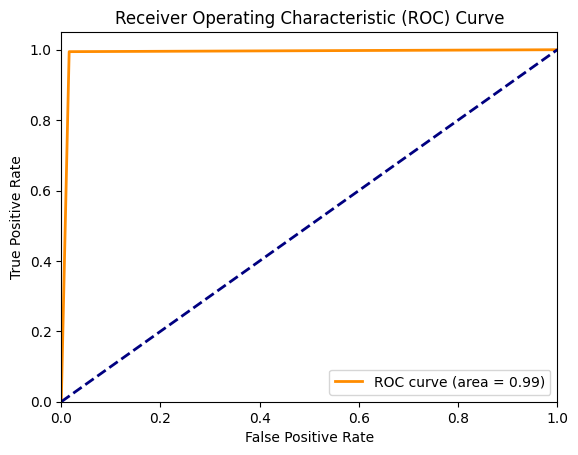

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr_bow)
auc_value = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 2. TFIDF

Wektoryzacja tekstu

In [52]:
vectorizer_tf = TfidfVectorizer(ngram_range=(1, 3))
X_train_tf = vectorizer_tf.fit_transform(X_train)
X_test_tf = vectorizer_tf.transform(X_test)

print(f'X_train shape: {X_train_tf.shape}')
print(f'X_test shape: {X_test_tf.shape}')

X_train shape: (675675, 3772016)
X_test shape: (168919, 3772016)


Model rergresji logistycznej

In [53]:
lr_tf = LogisticRegression(penalty='l2', max_iter=500, C=1, random_state=42)
lr_tf.fit(X_train_tf, y_train)
y_pred_lr_tf = lr_tf.predict(X_test_tf)
print(f'Accuracy of Logistic regression: {accuracy_score(y_test, y_pred_lr_tf)}')

Accuracy of Logistic regression: 0.9906286444982506


Raport klasyfikacji

In [54]:
cr = classification_report(y_test, y_pred_lr_tf)
print(cr)

              precision    recall  f1-score   support

           0       0.98      0.97      0.98     32481
           1       0.99      0.99      0.99    136438

    accuracy                           0.99    168919
   macro avg       0.99      0.98      0.98    168919
weighted avg       0.99      0.99      0.99    168919



Macierz konfuzji

In [55]:
cm = confusion_matrix(y_test, y_pred_lr_tf)

plot_confusion_matrix(cm)

In [56]:
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
print(f"False Positive Rate (FPR): {fpr:.4f}")
print(f"False Negative Rate (FNR): {fnr:.4f}")

False Positive Rate (FPR): 0.0273
False Negative Rate (FNR): 0.0051


Krzywa ROC

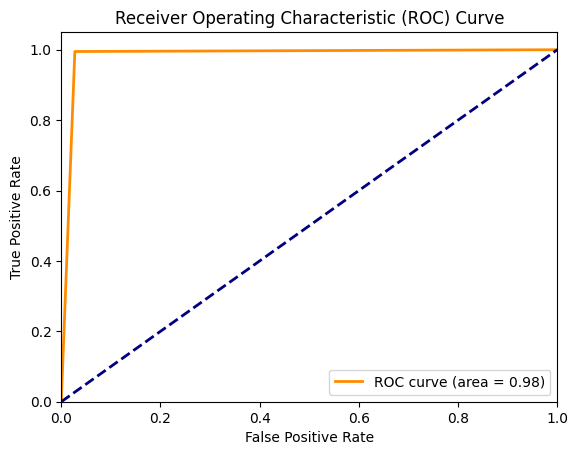

In [57]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lr_tf)
auc_value = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 3. Podsumowanie

Zbiór danych jaki otrzymałem jest niezbalansowany. Opinii negatywnych jest znacznie mniej niż pozytywnych. Można to naprawić przy pomocy różnych przykładowych technik: undersampling (zmniejszenie liczności klasy pozytywnej), oversampling(zwiększenie liczności klasy negatywnej), technika SMOTE (zwiększenie liczności klasy negatywnej poprzez generowanie sztucznych próbek na bazie już istniejących), ważenie określonych klas.

Aby znaleźć teksty podobnie tematycznie, na początku rozłożyłbym teksty na słowa, zastosował lemmatyzację i usunął stopwords. Następnie zastosowałbym wektoryzację a następnie klastrowanie. Na koniec przy pomocy algorytmu do oceny podobieństwa tekstów znalazłbym najbardziej podobne.

Zdecydowałem się usunąć recenzje neutralne (z rate 0.0) z uwagi na ich małą liczność oraz 'pustą' treść. Każdy wiersz w kolumnie 'description' dla 'rate' składał się z '0'. Ma to bardzo niską użyteczność dla modelu. Nie sprawdzi się gdy będzie potrzeba sklasyfikowania nowej recenzji neutralnej która będzie składała się z słów.

Przed przeprowadzeniem analizy statystycznej odnośnie słów, oczyściłem dane. Usunąłem znaki interpunkcyjne, znaki specjalne oraz niepotrzebne spacje. Można zastosować też lemmatization czyli sprowadzenie słów do postaci bezokolicznika co ujednolici recenzje, ale zrezygnowałem z tego z uwagi na zbyt długi czas potrzebny do przetworzenia takiego działania.

Podczas przeprowadzania analizy statystycznej ciekawym było, że recenzja pozytywna składa się z minimum 31 znaków. Recenzje negatywne były średnio dłuższe o jedno słowo, a w przypadku samych stopwords o 2. Na wykresach przedstawiających najczęściej występujące słowa, słowa bez stopwords oraz ngramy w recenzjach pozytywnych i negatywnych można zauważyć, że recenzje negatywne są bardzo ubogie w treść. W przypadku opinii pozytywnych jest wiele słów wyrażających emocje, odczucia, jakość otrzymanych usług, natomiast większość opinii negatywnych to tzw. stopwords, pojawiają się też wulgaryzmy. Nie użyłbym danych odnośnie opinii negatywnych do budowy modelu do celów innych niż treningowy. Biorąc pod uwagę informacje o źródle pochodzenia danych, myślę, że opinie pozytywne zostały zaciągnięte z portalu Opineo natomiast negatywne to Twitter lub YouTube.

Skorzystałem z 2 metod wektoryzacji tekstu - Bag of Words oraz TFIDF. Bag of Words rozkłada daną recenzje na wektor i zlicza ilość wystąpień danego słowa, natomaist w przypadku TFIDF określona zostaje waga danego słowa (im rzadziej występuje tym ma większe znaczenie dla wydźwięku recenzji). Wadą takich podejść jest nie uwzględnianie kolejności wsytępowania słów w recenzji.

Przy dwóch podejściach model regresji logistycznej osiąga bardzo wysokie, podobne wyniki: dla Bag of Words: 99.24% a dla TFIDF 99.06%. Z uwagi na niezbalansowanie danych, wysokie wyniki dla klasy 1 mogą być spowodowane tym, że model jest bardziej skłonny do przewidywania dominującej klasy.

Bardzo wysokie wartości dokładności, precyzji (procent pozytywnych przewidywań, które są rzeczywiście pozytywne), czułości (procent rzeczywistych pozytywów, które zostały poprawnie zidentyfikowane) oraz F1-Score wskazują, że model doskonale rozpoznaje zarówno pozytywne, jak i negatywne klasy. Najniższa wartość FPR na poziomie około 1.59% pokazuje, że model rzadko błędnie klasyfikuje negatywne przykłady jako pozytywne.

Wynik AUC (Area Under the Curve) dla Bag of Words wynoszący 0.99 oznacza, że model ma bardzo wysoką zdolność do rozróżniania między klasami pozytywną i negatywną. Krzywa ROC pokazuje, że model osiąga bardzo wysokie wartości True Positive Rate (TPR) przy minimalnych False Positive Rate (FPR).

Model, który użyłem ma wysoką szybkość uczenia, nawet dla dużych danych. Wyniki regresji logistycznej są łatwe do interpretacji. Wagi przypisane cechom (słowom) wskazują, jak wpływają one na wynik klasyfikacji. Możliwość dodania regularyzacji pomaga w redukcji nadmiernego dopasowania i selekcji cech. Natomiast słabymi stronami tego rodzaju modelu są: brak wychwytywania skomplikowanych nieliniowych relacji (np. związki między odległymi słowami w zdaniu), przy bardzo dużej liczbie cech (jak w przypadku dużych korpusów tekstowych), model może wymagać optymalizacji pod względem wydajności obliczeniowej i pamięciowej. Model zakłada liniowe relacje między cechami a klasami. W przypadku bardziej złożonych relacji w tekstach (np. ironii, kontekstu), regresja logistyczna może nie być wystarczająco elastyczna.


Model w tym przypadku można poprawić m.in. poprzez użycie bardziej jakościowych danych, optymalizację hiperparametrów i zrównoważenie danych.